Introduction

This notebook aims to conduct image recognition using transfer learning technique which involves using a pretrained model for a new econd task.The images will consist of shoes, sandals and boots which we will train our model to classify according to the label of the image.

Table of Contents

1.  Import prerequisite libraries

2. Upload the images folder and convert them  into a dataframe

3. Images visualiation   

4. splitting data into training and testing data

5. Applying various transformations to our images

6. Transfer Learning

7. model training

8. Predictions and model accuracy metrics

In [3]:
# importing prerequisite librarie
import pandas as pd 
import seaborn as sns
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import os
import random
import matplotlib.image as mpimg
from pathlib import Path
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
# path  to the directory that have the images
dir = r'../tochora/baba/shoe'


we are going to create a dataFrame made up of two columns; 1 Filepath which shows diffrent paths of our classes/images and  Labels which classsify what type of identity is our image, that is whether it is a shoe, sandal or boot.

In [5]:
# using path to manage our directory
image_dir = Path(dir)
#sercging for image files in Jpg or jpf formats
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))
#
labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepaths))
# buildinf a series o made up of root paths of the images
filepaths = pd.Series(filepaths, name='FILEPATH').astype(str)
# a series made up of labels of various files directories in root directory
labels = pd.Series(labels, name='Label')
# joinging the two series into one datafram
image_df = pd.concat([filepaths, labels], axis=1)
# reading contents of the dataframe
print(image_df.head())

                                   FILEPATH Label
0    ..\tochora\baba\shoe\Boot\boot (1).jpg  Boot
1   ..\tochora\baba\shoe\Boot\boot (10).jpg  Boot
2  ..\tochora\baba\shoe\Boot\boot (100).jpg  Boot
3  ..\tochora\baba\shoe\Boot\boot (101).jpg  Boot
4  ..\tochora\baba\shoe\Boot\boot (102).jpg  Boot


In [ ]:
# iterating through the dataframe to check labels of directories in our dataframe
for image_class in os.listdir(dir):
    print(image_class)

Boot
Sandal
Shoe


In [ ]:
# shape of our dataframe
image_df.shape

(1792, 2)

This dataframe has 1792 rows and 2 columns

Images Visualisation

Here we will visualize  a sample of images in our dataframe that is 24 images

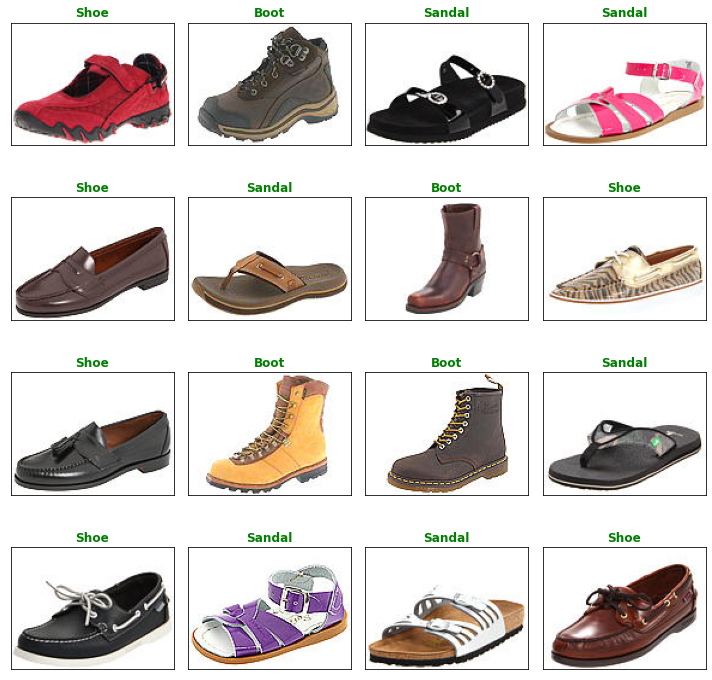

In [ ]:
#specifying how images will be selected throughtout the dataframe of size 24 then creating an array
random_index = np.random.randint(0, len(image_df), 24)
# specification of the parameters of our figure
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
# iterating through the 
for i, ax in enumerate(axes.flat):
    #reading each image file
    ax.imshow(plt.imread(image_df.FILEPATH[random_index[i]]))
    # reading  various labels where that represent randomly selected images
    ax.set_title(image_df.Label[random_index[i]], fontdict={'color':'green', 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

In [ ]:
# suing a function that will show images in a single directory
def load_image(filepath):
    plt.figure(figsize=(20, 20))
    for i in range(6):
        file = random.choice(os.listdir(filepath))
        image_path = os.path.join(filepath, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 6, i + 1)
        ax.title.set_text(file)
        plt.imshow(img)

In [ ]:
shoe = r'../tochora/baba/Shoe vs Sandal vs Boot Dataset/Shoe'

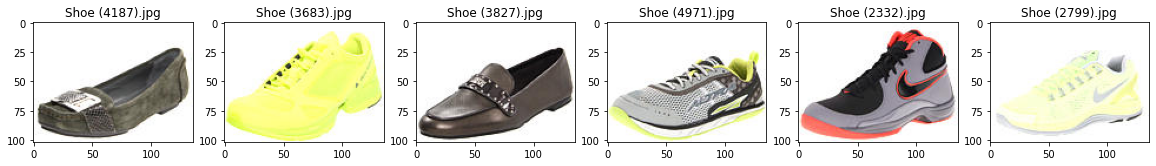

In [ ]:
# showing shoes
load_image(shoe)

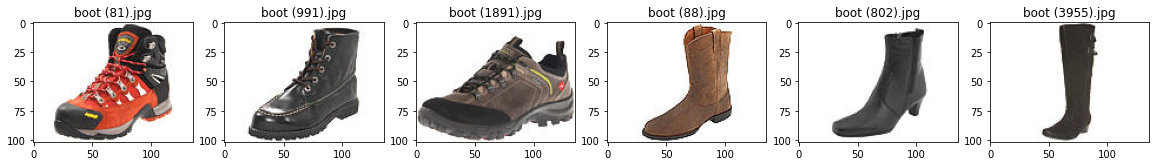

In [ ]:
# showing boots
Boot = r'../tochora/baba/Shoe vs Sandal vs Boot Dataset/Boot'
load_image(Boot)

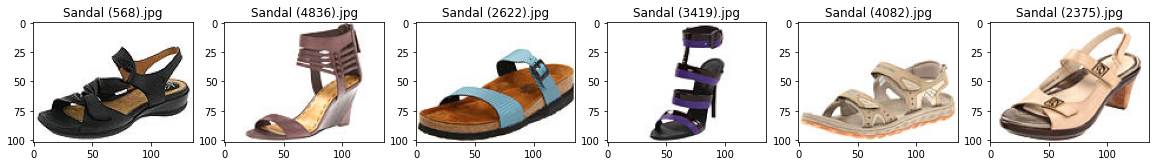

In [ ]:
# showing sandals
sandal = r'../tochora/baba/Shoe vs Sandal vs Boot Dataset/Sandal'
load_image(sandal)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Data preprocesing

splitting our dataframe into training and testing data which will be used to make generators which have normalized input images by scalling them between pixels of -1 and 1.

In [ ]:
# splitting our dataframe into training and testing data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True)
#normalizing input images pixels by scalling them to be between 1 and -1
training_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

Our data will be further split into 3 diffrent classes that is training data for training our deep learning model, testig data for checking the preformanceof our model after validation data has fine-tuned the parameters in it.

In [ ]:
#
train_images = training_generator.flow_from_dataframe(dataframe= train_df, x_col = "FILEPATH", y_col = 'Label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = training_generator.flow_from_dataframe(dataframe= train_df, x_col = "FILEPATH", y_col = 'Label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation')
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col="FILEPATH", y_col='Label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)

Found 1147 validated image filenames belonging to 3 classes.
Found 286 validated image filenames belonging to 3 classes.
Found 359 validated image filenames belonging to 3 classes.


checking the shape of the model so that we can know the input shape of the images that will we use in training of pre-trained model.in this case we will use input shape of (224, 224, 3) where 224, 224 specify height and width

In [ ]:

img, label = train_images.next()
print(img.shape)

(32, 224, 224, 3)


Applying various image transformations that augments image batches 

In [ ]:
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    # changing the dimensions of images height and width to 224
    layers.experimental.preprocessing.Resizing(224, 224),
    # rescalling images into [0, 255] range
    layers.experimental.preprocessing.Rescaling(1./255),
    # flipping the images horizontall during training
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    # rotating images by 0.1 degrees
    layers.experimental.preprocessing.RandomRotation(0.1),
    # zooming our images by 0.1 multiple
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

Transfer Learning

This is a powerful deep learning method where we reuse a repurposed model that was developed earlier for a particular task without necessarly training the model for the second task without training from the start. It helps us to avoid using alot of resources and computing power to train a model for our task.The following parameters will be used:

include top: we will set it to false since we won't include the top layer of the pretrained model.

input shape: This is an option shape tuple where we will set the height and width of the model as 224 and 224 wit 3 set as channel_last data format. 

weights: we will use the defaults 'imagenet' that were used by the pretrained model.

pooling: a feature extraction where the global average pooling will be applied to the output  of the ladt convolutional block thus resulting with 2D output.

In [ ]:
from tensorflow.keras.models import Sequential
#using sequential which deals with ordering and sequencing of layers within the model
inception_model = Sequential() 
# applying the parameters
pretrained_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, pooling='avg',classes=3, weights='imagenet')
# moving all layer weights in our model from trainable to non-trainable
for layer in pretrained_model.layers:
    layer.trainable = False 
# adding up the pretrained model
inception_model.add(pretrained_model)

In [ ]:
#removing dimensins in our model except one
inception_model.add(tf.keras.layers.Flatten())
#  using 200 hidden fully-connected layers
inception_model.add(tf.keras.layers.Dense(200, activation='relu'))
#dropping models randomly with a probability of 20%
inception_model.add(tf.keras.layers.Dropout(0.2))
inception_model.add(tf.keras.layers.Dense(3, activation='softmax'))

below is the summary of the model which includes name and types, output shape and weights of all layers used in the model.

In [ ]:
#
inception_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 200)               409800    
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                 603       
                                                                 
Total params: 22,213,187
Trainable params: 410,403
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
## model compilation which checks format errors, models learning rate and defines the loss function that will be used
inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# fitting our model
mmodel = inception_model.fit(train_images, epochs= 10,validation_data=val_images)

Epoch 1/10
36/36 [==============================] - 344s 9s/step - loss: 0.5205 - accuracy: 0.7908 - val_loss: 0.2050 - val_accuracy: 0.9510
Epoch 2/10
36/36 [==============================] - 351s 10s/step - loss: 0.1761 - accuracy: 0.9451 - val_loss: 0.1167 - val_accuracy: 0.9650
Epoch 3/10
36/36 [==============================] - 353s 10s/step - loss: 0.1197 - accuracy: 0.9625 - val_loss: 0.0933 - val_accuracy: 0.9720
Epoch 4/10
36/36 [==============================] - 349s 10s/step - loss: 0.0966 - accuracy: 0.9704 - val_loss: 0.0761 - val_accuracy: 0.9720
Epoch 5/10
36/36 [==============================] - 352s 10s/step - loss: 0.0745 - accuracy: 0.9852 - val_loss: 0.0728 - val_accuracy: 0.9755
Epoch 6/10
36/36 [==============================] - 352s 10s/step - loss: 0.0653 - accuracy: 0.9808 - val_loss: 0.0594 - val_accuracy: 0.9860
Epoch 7/10
36/36 [==============================] - 346s 10s/step - loss: 0.0510 - accuracy: 0.9913 - val_loss: 0.0536 - val_accuracy: 0.9895
Epoch 8

Below is a plot that shows our model performance. Seems our model has an overfittting problem but let us see if it will mess with the models predictions

Text(0.5, 0.98, 'Plots of model performance')

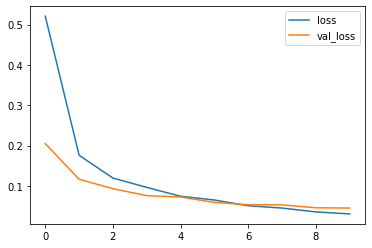

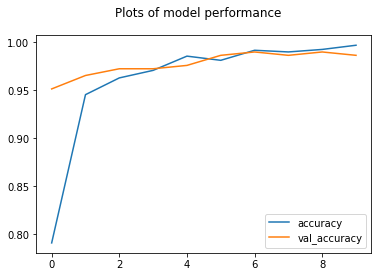

In [ ]:
model_history = pd.DataFrame(mmodel.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()
plt.suptitle("Plots of model performance")

Below is a function that will feed images into our model and show the predictions of the labels the model has assigned to the images fed into it.Since it is a classification problem, we will have multiple images predictions

In [ ]:
# making predictions using the model
pred = inception_model.predict(test_images)
# returning an index of maximum elements in the predicted values
pred = np.argmax(pred, axis=1)
#extracting labels and their indices as a dictionary
Labels = (train_images.class_indices)
# switching places of labels and indices into the right format
Labels = dict((v,k) for k, v in Labels.items())
# making predictions 
pred1 = [Labels[k] for k in pred]
print(f'first 5 predicted images: {pred1[:5]}')

12/12 [==============================] - 89s 7s/step
first 5 predicted images: ['Sandal', 'Sandal', 'Shoe', 'Sandal', 'Boot']


Below is a plot of the test images and predicted images.

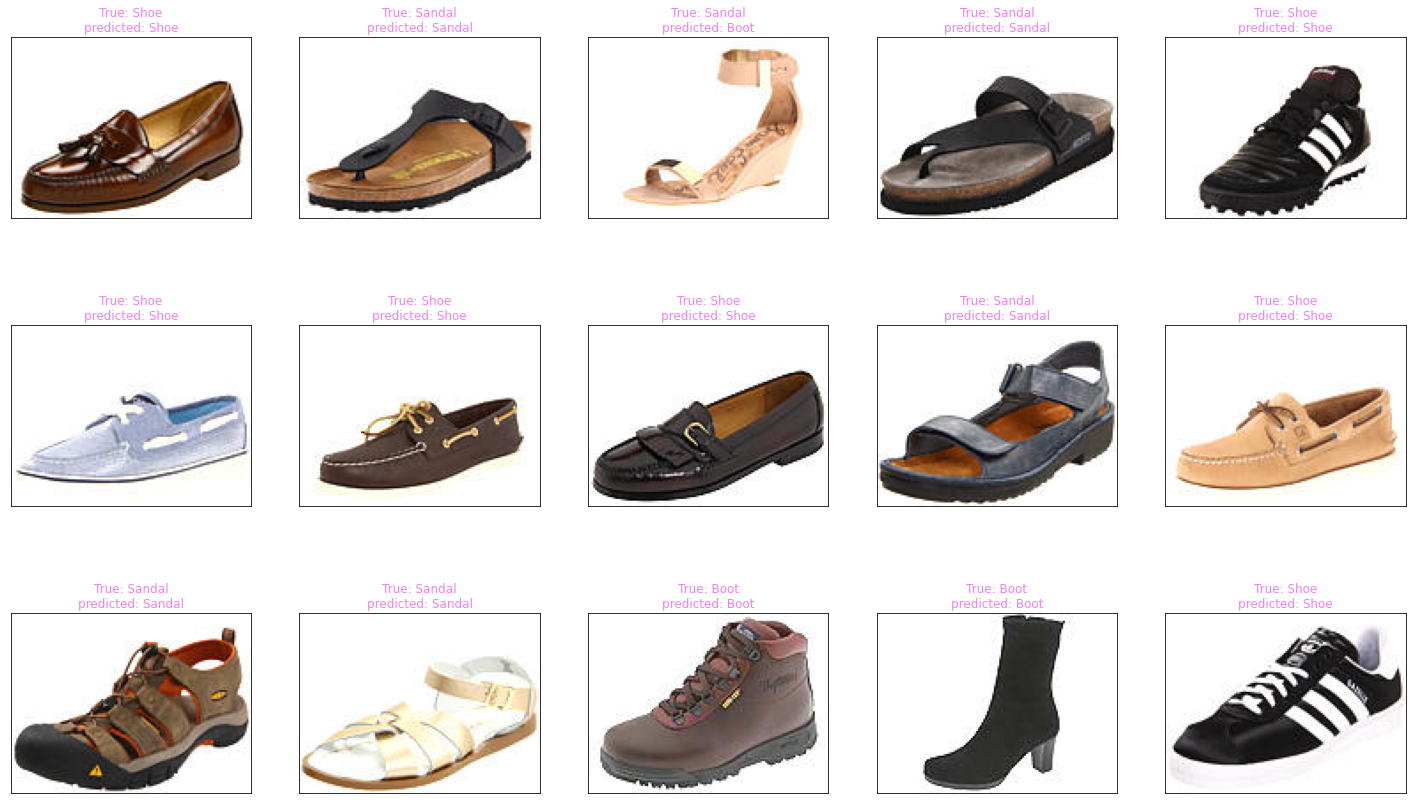

<Figure size 432x288 with 0 Axes>

In [ ]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, subplot_kw= {"xticks": [], "yticks" : []}, figsize=(25, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.FILEPATH.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = 'red'
    else:
        color = 'violet'
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\npredicted: {pred1[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

wow! it seems our model has made predictons very well, it has only one miss where it classify a sandal as a shoe. Let us check various metrics in the classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_test = list(test_df.Label)
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

        Boot       0.98      0.97      0.98       115
      Sandal       0.98      0.99      0.99       116
        Shoe       0.98      0.98      0.98       128

    accuracy                           0.98       359
   macro avg       0.98      0.98      0.98       359
weighted avg       0.98      0.98      0.98       359



In [ ]:
report = classification_report(y_test, pred1, output_dict=True)
df = pd.DataFrame(report).transpose()
df 

,precision,recall,f1-score,support
Boot,0.982456,0.973913,0.978166,115.000000
Sandal,0.982906,0.991379,0.987124,116.000000
Shoe,0.976562,0.976562,0.976562,128.000000
accuracy,0.980501,0.980501,0.980501,0.980501
macro avg,0.980642,0.980618,0.980618,359.000000
weighted avg,0.980500,0.980501,0.980489,359.000000
